In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv('iphone.csv')
df.head()

,productAsin,country,date,isVerified,ratingScore,reviewTitle,reviewDescription,reviewUrl,reviewedIn,variant,variantAsin
0,B09G9BL5CP,India,11-08-2024,True,4,No charger,"Every thing is good about iPhones, there's not...",https://www.amazon.in/gp/customer-reviews/R345...,Reviewed in India on 11 August 2024,Colour: MidnightSize: 256 GB,B09G9BQS98
1,B09G9BL5CP,India,16-08-2024,True,5,iPhone 13 256GB,"It look so fabulous, I am android user switche...",https://www.amazon.in/gp/customer-reviews/R2HJ...,Reviewed in India on 16 August 2024,Colour: MidnightSize: 256 GB,B09G9BQS98
2,B09G9BL5CP,India,14-05-2024,True,4,Flip camera option nill,I tried to flip camera while recording but no ...,https://www.amazon.in/gp/customer-reviews/R3Y7...,Reviewed in India on 14 May 2024,Colour: MidnightSize: 256 GB,B09G9BQS98
3,B09G9BL5CP,India,24-06-2024,True,5,Product,100% genuine,https://www.amazon.in/gp/customer-reviews/R1P9...,Reviewed in India on 24 June 2024,Colour: MidnightSize: 256 GB,B09G9BQS98
4,B09G9BL5CP,India,18-05-2024,True,5,Good product,Happy to get the iPhone 13 in Amazon offer,https://www.amazon.in/gp/customer-reviews/R1XI...,Reviewed in India on 18 May 2024,Colour: MidnightSize: 256 GB,B09G9BQS98


In [3]:
df.shape

(3062, 11)

In [4]:
df.isnull().sum()

productAsin           0
country               0
date                  0
isVerified            0
ratingScore           0
reviewTitle           0
reviewDescription    86
reviewUrl            16
reviewedIn            0
variant               0
variantAsin           0
dtype: int64

In [5]:
df['country'].value_counts()

country
India                   2229
United States            579
Japan                    158
United Arab Emirates      80
Mexico                    11
Canada                     4
Egypt                      1
Name: count, dtype: int64

In [6]:
df.groupby('country')['ratingScore'].mean()

country
Canada                  4.500000
Egypt                   5.000000
India                   3.810229
Japan                   3.310127
Mexico                  4.909091
United Arab Emirates    3.912500
United States           3.633851
Name: ratingScore, dtype: float64

<Axes: xlabel='ratingScore'>

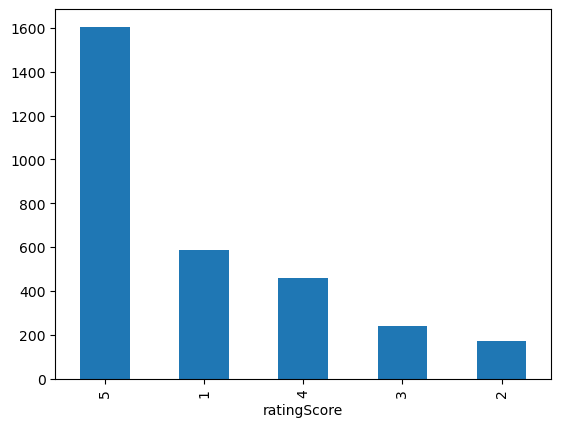

In [7]:
df['ratingScore'].value_counts().plot(kind='bar')

In [8]:
new_df = df.copy()
new_df = new_df[['reviewDescription', 'ratingScore']]

In [9]:
new_df.dropna(inplace=True)

In [10]:
new_df.shape

(2976, 2)

In [11]:
new_df['ratingScore'] = new_df['ratingScore'].apply(lambda x:'Bad' if x<= 3 else 'Good')

In [12]:
text = ' '.join(new_df['reviewDescription'])

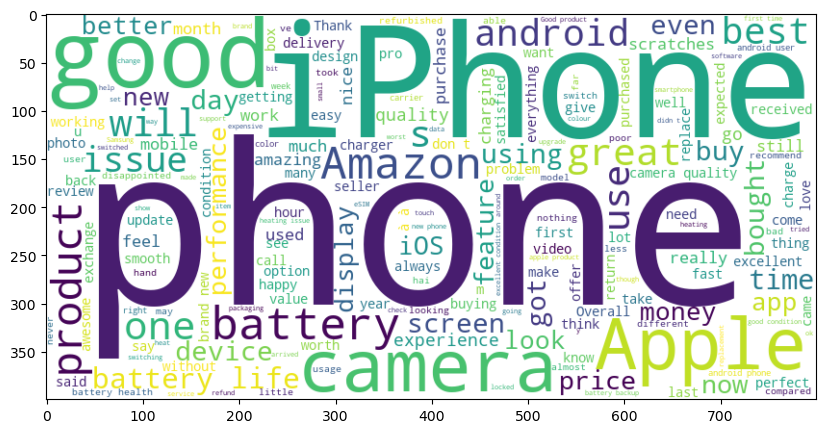

In [13]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')

In [14]:
lemma = WordNetLemmatizer()

In [15]:
def preprocess_text(review):
    
    review = review.lower()
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = review.split()
    review = [word for word in review if not word in set(stopwords.words('english'))]
    review = [lemma.lemmatize(word) for word in review]
    return ' '.join(review)

new_df['cleaned_review'] = new_df['reviewDescription'].apply(preprocess_text)

In [16]:
le = LabelEncoder()
new_df['ratingScore'] = le.fit_transform(new_df['ratingScore'])

In [18]:
x = new_df['cleaned_review']
y = new_df['ratingScore']

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=1)

In [20]:
tfidf = TfidfVectorizer(max_features=5000)
x_train_tfidf = tfidf.fit_transform(x_train)
x_test_tfidf = tfidf.transform(x_test)

In [23]:
classifiers = {'Random Forest': RandomForestClassifier(), 'Logistic Regression': LogisticRegression(),
              'Extra Tree': ExtraTreesClassifier()}

In [25]:
for name, clf in classifiers.items():
    pipeline = Pipeline([('classifier', clf)])
    pipeline.fit(x_train_tfidf, y_train)
    y_pred = pipeline.predict(x_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy : {accuracy}")

Random Forest Accuracy : 0.860738255033557
Logistic Regression Accuracy : 0.8439597315436241
Extra Tree Accuracy : 0.8691275167785235


In [28]:
best_model_name = ""
best_accuracy = 0
best_pipeline = None

for name, clf in classifiers.items():
    pipeline = Pipeline([('classifier', clf)])
    pipeline.fit(x_train_tfidf, y_train)
    y_pred = pipeline.predict(x_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy : {accuracy:.4f}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_name = name
        best_pipeline = pipeline
        
print(f"\n best model is {best_model_name} with accuracy {best_accuracy:.4f}")
y_pred_best = best_pipeline.predict(x_test_tfidf)
final_accuracy = accuracy_score(y_test, y_pred_best)
print(f"\n Final Accuary of best model {best_model_name}: {final_accuracy:.4f}")

Random Forest Accuracy : 0.8624
Logistic Regression Accuracy : 0.8440
Extra Tree Accuracy : 0.8742

 best model is Extra Tree with accuracy 0.8742

 Final Accuary of best model Extra Tree: 0.8742
